<a href="https://colab.research.google.com/github/anaaaraujoo/breast-tissue-classification/blob/main/breast_tissue_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Breast tissue classification end-to-end platform

In [ ]:
# Useful libraries
!pip install tensorflow scikit-learn matplotlib seaborn pandas streamlit

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Downloading the dataset
!pip install medmnist
from medmnist import BreastMNIST

In [ ]:
# Data comprehension and analysis

In [ ]:
# Preprocessing and loading the data
def load_data():
  train_data = BreastMNIST(split='train', download=True)
  val_data = BreastMNIST(split='val', download=True)
  test_data = BreastMNIST(split='test', download=True)

  x_train = train_data.imgs
  y_train = train_data.labels

  x_val = val_data.imgs
  y_val = val_data.labels

  x_test = test_data.imgs
  y_test = test_data.labels

  return (x_train, y_train), (x_val, y_val), (x_test, y_test)

def preprocess_data(x_train, x_val, x_test, y_train, y_val, y_test):
  # Normalizing the pixels in the interval [0, 1]
  x_train = x_train.astype("float32") / 255
  x_val = x_val.astype("float32") / 255
  x_test = x_test.astype("float32") / 255

  # Reshape data to include the channel dimension (for grayscale images)
  x_train = np.expand_dims(x_train, axis=-1)
  x_val = np.expand_dims(x_val, axis=-1)
  x_test = np.expand_dims(x_test, axis=-1)

  return x_train, x_val, x_test,

In [ ]:
# Define the Convolution Neural Network model
def create_cnn_model(input_shape, num_classes = 2):
  model = keras.Sequential([
      # 1st convolutional block
      layers.Conv2D(64, (3, 3), activation = 'relu', input_shape = input_shape),
      layers.BatchNormalization(),
      layers.MaxPooling2D((2, 2)),
      layers.Dropout(0.25),

      # 2nd convolutional block
      layers.Conv2D(128, (3, 3), activation = 'relu'),
      layers.BatchNormalization(),
      layers.MaxPooling2D((2, 2)),
      layers.Dropout(0.25),

      # Ftatten layers
      layers.Flatten(),
      layers.Dense(128, activation = 'relu'),
      layers.BatchNormalization(),
      layers.Dropout(0.5),

      # Fully connected layers
      layers.Dense(1, activation = 'sigmoid')
  ])

  return model

In [ ]:
# Training the model
def train_model(model, x_train, y_train, x_val, y_val, epochs = 5, batch_size = 32):

  model.compile(
      optimizer = 'adam',
      loss = 'binary_crossentropy',
      metrics = ['accuracy', 'precision', 'recall', 'f1_score']
  )

  history = model.fit(
      x_train, y_train,
      validation_data = (x_val, y_val),
      epochs = epochs,
      batch_size = batch_size,
      verbose = 1
  )
  return model, history

In [ ]:
# Evaluating the model
def evaluate_model(model, x_test, y_test):
  y_prediction_prob = model.predict(x_test)
  y_prediction = np.round(y_prediction_prob)
  loss, accuracy, precision, recall, f1_score = model.evaluate(x_test, y_test, verbose = 0)
  print("Test results:")
  print(f"Loss: {loss:.4f}")
  print(f"Accuracy: {accuracy:.4f}")
  print(f"Precision: {precision:.4f}")
  print(f"Recall: {recall:.4f}")
  print(f"F1 Score: {f1_score:.4f}")

  print("\nClassification Report:")
  print(classification_report(y_test, y_prediction))

  # Plotting the confusiion matrix
  plt.figure(figsize = (8, 6))
  conf_matrix = confusion_matrix(y_test, y_prediction)
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Benign', 'Malignant'],
                yticklabels=['Benign', 'Malignant'])
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()

  return y_prediction, y_prediction_prob

# Visualizing some of the test predictions
def visualize_predictions(X_test, y_test, y_pred, y_pred_prob, num_samples= 4):
  fig, axes = plt.subplots(2, num_samples // 2, figsize=(16, 8))
  axes = axes.ravel()
  indices = np.random.choice(len(X_test), num_samples, replace=False)
  for i, idx in enumerate(indices):
  # Display image
    if X_test.shape[-1] == 1:
        axes[i].imshow(X_test[idx].squeeze(), cmap='gray')
    else:
        axes[i].imshow(X_test[idx])

    true_label = 'Malignant' if y_test[idx] == 1 else 'Benign'
    pred_label = 'Malignant' if y_pred[idx] == 1 else 'Benign'
    confidence = y_pred_prob[idx][0] if y_pred[idx] == 1 else 1 - y_pred_prob[idx][0]

    color = 'green' if y_test[idx] == y_pred[idx] else 'red'
    axes[i].set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}', color=color)
    axes[i].axis('off')

  plt.tight_layout()
  plt.show()

In [ ]:
def main():
  print("Loading the BreastMNIST dataset:")
  (x_train, y_train), (x_val, y_val), (x_test, y_test) = load_data()

  print("Preprocessing the data:")
  x_train, x_val, x_test = preprocess_data(x_train, x_val, x_test, y_train, y_val, y_test)

  print("Creating the CNN model")
  input_shape = x_train.shape[1:]
  model = create_cnn_model(input_shape)
  print(model.summary())

  print("Training phase")
  model, history = train_model(model, x_train, y_train, x_val, y_val, epochs = 5, batch_size = 32)

  print("Evaluating the model")
  y_pred, y_pred_prob = evaluate_model(model, x_test, y_test)

  print("Visualizing predictions:")
  visualize_predictions(x_test, y_test, y_pred, y_pred_prob)

  model.save('breast_cancer_classification_model.h5')

  return model, history

Loading the BreastMNIST dataset:
Preprocessing the data:
Creating the CNN model


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 26, 26, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 26, 26, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 11, 11, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 485,633 (1.85 MB)

 Trainable params: 484,993 (1.85 MB)

 Non-trainable params: 640 (2.50 KB)

None
Training phase
Epoch 1/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.5840 - f1_score: 0.8467 - loss: 0.8741 - precision: 0.8154 - recall: 0.5569 - val_accuracy: 0.7308 - val_f1_score: 0.8444 - val_loss: 0.6159 - val_precision: 0.7308 - val_recall: 1.0000
Epoch 2/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.6705 - f1_score: 0.8431 - loss: 0.6687 - precision: 0.8514 - recall: 0.6642 - val_accuracy: 0.7308 - val_f1_score: 0.8444 - val_loss: 0.5912 - val_precision: 0.7308 - val_recall: 1.0000
Epoch 3/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.6900 - f1_score: 0.8357 - loss: 0.6437 - precision: 0.8389 - recall: 0.7038 - val_accuracy: 0.7308 - val_f1_score: 0.8444 - val_loss: 0.5762 - val_precision: 0.7308 - val_recall: 1.0000
Epoch 4/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.7210 - f1_score: 0.8675 - loss: 0.6090 - precision: 0.8851 - recall: 0.7332 - val_accuracy: 0.7308 - val_f1_score: 0.8444 - val_loss: 0.5746 - val_precision: 0.7308

Evaluating the model
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Test results:
Loss: 0.6044
Accuracy: 0.7308
Precision: 0.7308
Recall: 1.0000
F1 Score: 0.8444

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        42
           1       0.73      1.00      0.84       114

    accuracy                           0.73       156
   macro avg       0.37      0.50      0.42       156
weighted avg       0.53      0.73      0.62       156



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


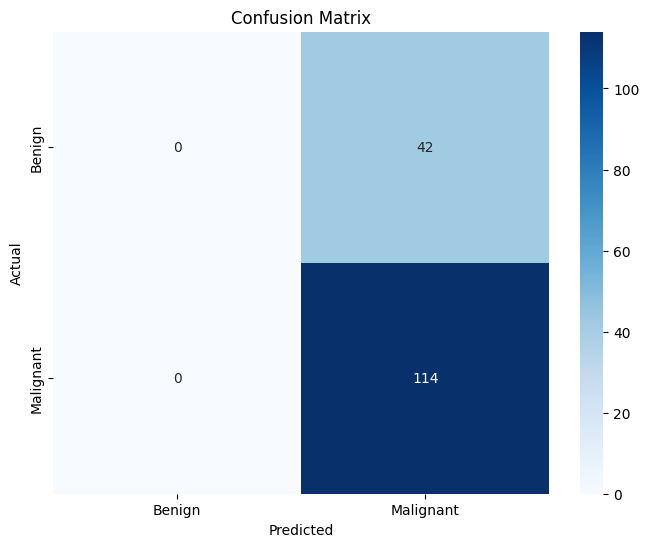

Visualizing predictions:


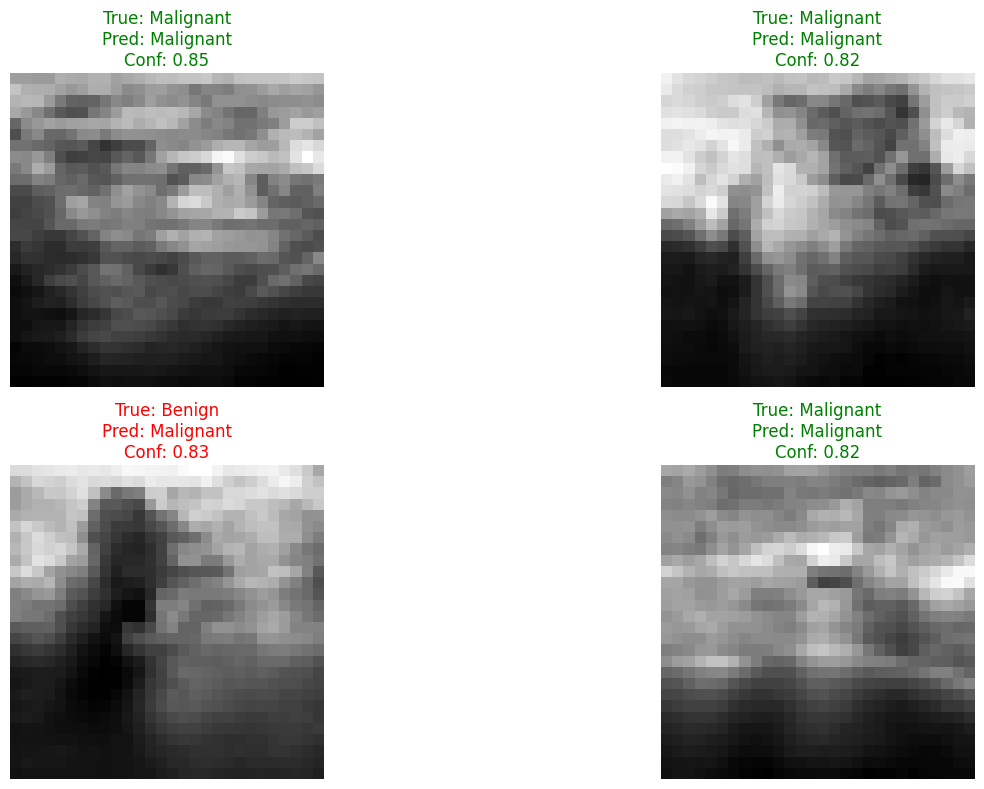

In [ ]:
if __name__ == "__main__":
  model, history = main()